In [1]:
# package import
import copy
import random
import operator
import os, math
import re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from os import path
from PIL import Image
from stop_words import get_stop_words
from collections import Counter, defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords 

import torch
import torch.utils.data as tud
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# read in the data 
def load_data(data_file):
    return pd.read_csv(data_file)

In [3]:
# prepare test label set, baseline label set, and proposed label set 
test = load_data("test.csv")
true_labels = load_data("test_labels.csv")
proposed = load_data("model_submission.csv")
baseline = load_data("NBSVM_submission.csv")

In [4]:
# keep only the test label that are for testing 
true_labels = true_labels[(true_labels['toxic'] != -1) & 
                          (true_labels['severe_toxic'] != -1) & 
                          (true_labels['obscene'] != -1) & 
                          (true_labels['threat'] != -1) & 
                          (true_labels['insult'] != -1) &
                          (true_labels['identity_hate'] != -1)]

In [5]:
# define 6 labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [6]:
true_labels = true_labels.merge(test, on=['id','id'])

In [7]:
proposed = proposed.merge(test, on=['id','id'])
proposed = proposed.merge(true_labels['id'], on=['id','id'])

In [8]:
baseline = baseline.merge(test, on=['id','id'])
baseline = baseline.merge(true_labels['id'], on=['id','id'])

In [9]:
true_labels.shape

(63978, 8)

In [10]:
true_labels.corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.234181,0.748014,0.171775,0.713363,0.317424
severe_toxic,0.234181,1.000000,0.303427,0.161685,0.285268,0.258284
obscene,0.748014,0.303427,1.000000,0.147123,0.753652,0.317549
threat,0.171775,0.161685,0.147123,1.000000,0.153406,0.116039
insult,0.713363,0.285268,0.753652,0.153406,1.000000,0.373130
identity_hate,0.317424,0.258284,0.317549,0.116039,0.373130,1.000000


In [11]:
proposed.shape

(63978, 8)

In [12]:
proposed.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0.998436,0.002746,0.038863,0.005719,0.077486,0.004905,Thank you for understanding. I think very high...
1,000247e83dcc1211,0.998117,0.005032,0.067401,0.004666,0.124376,0.007064,:Dear god this site is horrible.
2,0002f87b16116a7f,0.999719,0.006814,0.276917,0.008384,0.118999,0.146837,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,0.999040,0.003127,0.035480,0.005985,0.053113,0.006158,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,0.998925,0.002818,0.033011,0.003811,0.054987,0.004150,""" \n\n == Before adding a new product to the l..."


In [13]:
proposed.corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,-0.082661,0.033023,-0.143680,0.020852,-0.025034
severe_toxic,-0.082661,1.000000,0.614206,0.240666,0.638739,0.282177
obscene,0.033023,0.614206,1.000000,0.080937,0.793492,0.189628
threat,-0.143680,0.240666,0.080937,1.000000,0.101018,0.105393
insult,0.020852,0.638739,0.793492,0.101018,1.000000,0.305075
identity_hate,-0.025034,0.282177,0.189628,0.105393,0.305075,1.000000


In [14]:
baseline.shape

(63978, 8)

In [15]:
baseline.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0.005928,0.000272,0.002274,0.000333,0.003634,0.000436,Thank you for understanding. I think very high...
1,000247e83dcc1211,0.110544,0.000676,0.004749,0.000133,0.007768,0.000469,:Dear god this site is horrible.
2,0002f87b16116a7f,0.234279,0.000234,0.020630,0.000180,0.007641,0.001509,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,0.004781,0.000192,0.003052,0.000103,0.002288,0.000262,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,0.003949,0.000411,0.002530,0.000091,0.002075,0.000333,""" \n\n == Before adding a new product to the l..."


In [16]:
baseline.corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.347239,0.792484,0.156733,0.740643,0.298112
severe_toxic,0.347239,1.000000,0.466178,0.170960,0.508310,0.311480
obscene,0.792484,0.466178,1.000000,0.126399,0.781420,0.276897
threat,0.156733,0.170960,0.126399,1.000000,0.146093,0.107531
insult,0.740643,0.508310,0.781420,0.146093,1.000000,0.366691
identity_hate,0.298112,0.311480,0.276897,0.107531,0.366691,1.000000


In [17]:
for i in labels:
    proposed[i] = proposed[i].apply(lambda x: 1 if x >= 0.5000000000000000 else 0)

In [18]:
for i in labels:
    baseline[i] = baseline[i].apply(lambda x: 1 if x >= 0.5000000000000000 else 0)

In [19]:
proposed.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,1,0,0,0,0,0,Thank you for understanding. I think very high...
1,000247e83dcc1211,1,0,0,0,0,0,:Dear god this site is horrible.
2,0002f87b16116a7f,1,0,0,0,0,0,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,1,0,0,0,0,0,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,1,0,0,0,0,0,""" \n\n == Before adding a new product to the l..."


In [20]:
baseline.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0,0,0,0,0,0,Thank you for understanding. I think very high...
1,000247e83dcc1211,0,0,0,0,0,0,:Dear god this site is horrible.
2,0002f87b16116a7f,0,0,0,0,0,0,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,0,0,0,0,0,0,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,0,0,0,0,0,0,""" \n\n == Before adding a new product to the l..."


In [21]:
# get english stop words 
stop_words = get_stop_words('english')
stop_words.append('')

# add single letter to the stop words set 
for x in range(ord('b'), ord('z')+1):
    stop_words.append(chr(x))
    
stopwords = set(stop_words)

In [22]:
# get sub category data
def subset(df, category):
    return df[df[category] == 1]

In [23]:
def word_cloud_true(df, category):
    
    data = subset(df, category)
    
    text = " ".join(comment for comment in data.comment_text)
    print ("There are {} words in the combination of {} review.".format(len(text), category))
    
    wordcloud = WordCloud(stopwords = stopwords, 
                          background_color = "white", 
                          max_font_size = 50, 
                          max_words = 200).generate(text)

    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.savefig(i+' test_true word.jpg')
    plt.show()

There are 1491034 words in the combination of toxic review.


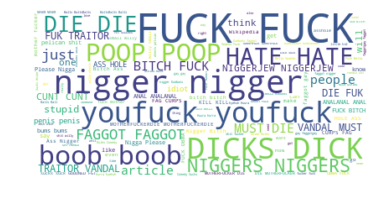

There are 268524 words in the combination of severe_toxic review.


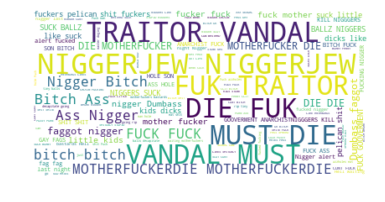

There are 991399 words in the combination of obscene review.


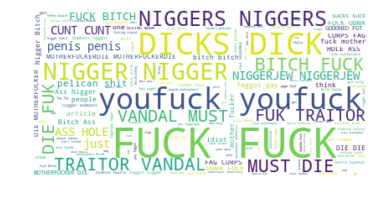

There are 71461 words in the combination of threat review.


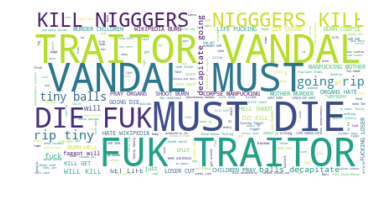

There are 896276 words in the combination of insult review.


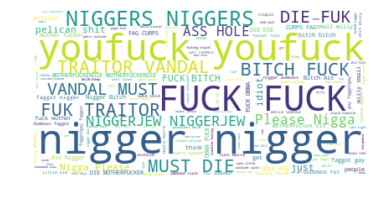

There are 232878 words in the combination of identity_hate review.


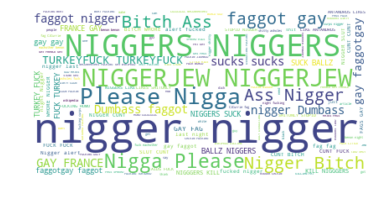

In [24]:
for i in labels:
    word_cloud_true(true_labels, i)

In [25]:
def word_cloud_predict(df, category):
    
    data = subset(df, category)
    
    text = " ".join(comment for comment in data.comment_text)
    print ("There are {} words in the combination of {} review.".format(len(text), category))
    
    wordcloud = WordCloud(stopwords = stopwords, 
                          background_color = "white", 
                          max_font_size = 50, 
                          max_words = 200).generate(text)

    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.savefig(i+' predict word.jpg')
    plt.show()

There are 24591819 words in the combination of toxic review.


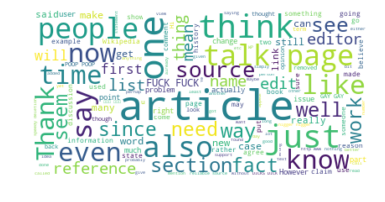

There are 434560 words in the combination of severe_toxic review.


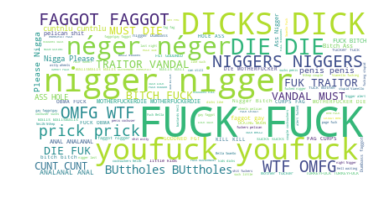

There are 3126895 words in the combination of obscene review.


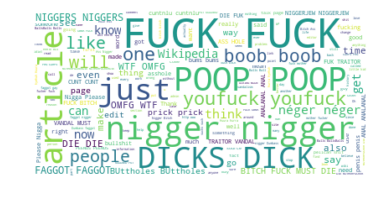

There are 105772 words in the combination of threat review.


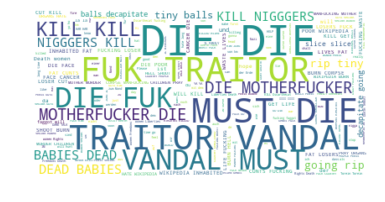

There are 1589596 words in the combination of insult review.


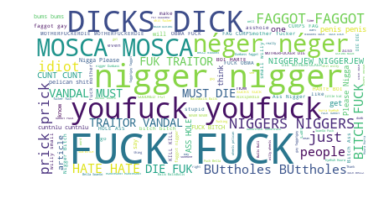

There are 235280 words in the combination of identity_hate review.


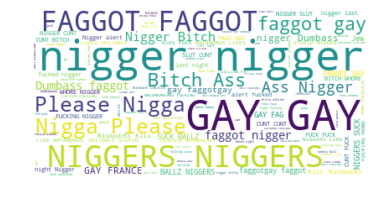

In [26]:
for i in labels:
    word_cloud_predict(proposed, i)

In [27]:
def word_cloud_baseline(df, category):
    
    data = subset(df, category)
    
    text = " ".join(comment for comment in data.comment_text)
    print ("There are {} words in the combination of {} review.".format(len(text), category))
    
    wordcloud = WordCloud(stopwords = stopwords, 
                          background_color = "white", 
                          max_font_size = 50, 
                          max_words = 200).generate(text)

    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.savefig(i+' baseline word.jpg')
    plt.show()

There are 1947305 words in the combination of toxic review.


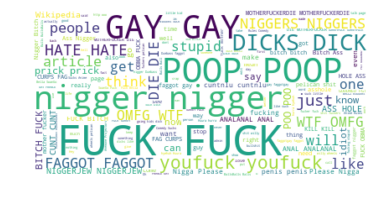

There are 140749 words in the combination of severe_toxic review.


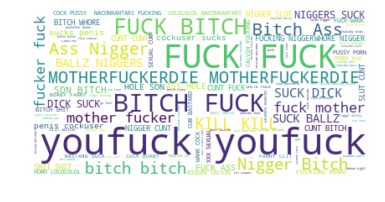

There are 980104 words in the combination of obscene review.


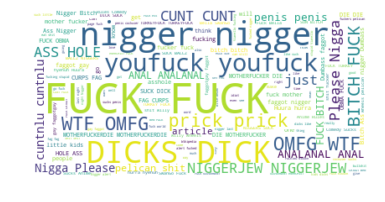

There are 50060 words in the combination of threat review.


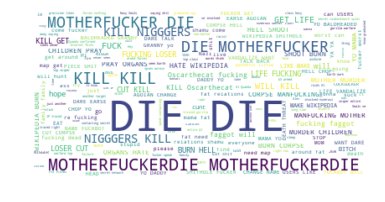

There are 649199 words in the combination of insult review.


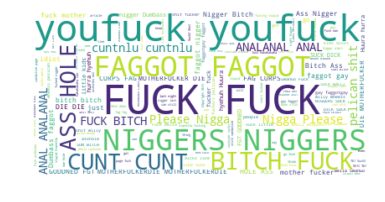

There are 141828 words in the combination of identity_hate review.


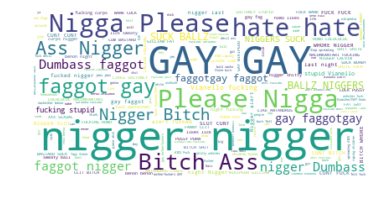

In [28]:
for i in labels:
    word_cloud_baseline(baseline, i)